# Single Cell Sequencing: counts downsampling experiment

We re-run quality control for multiple examples of count downsampling. The idea is to emulete what will happen 


In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
import anndata as ad
import matplotlib.pyplot as plt
import os 
import config as general_paths
from datetime import date
today = date.today()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [4]:
figure_path = general_paths.figures_path
data_path = general_paths.data_path
output_path = general_paths.output_path
input_path = output_path
local_path = general_paths.local_path

### SECTION I: Downsampling and QC in the counts downsampled matrix

In [59]:
fraction_downsample = 0.50

### import the adata file PRE-QC
adata = ad.read_h5ad(os.path.join(input_path , 'campari_scs_raw.h5ad'))

print(adata.shape)

(1152, 55421)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [60]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(axis = 1) ## this sums over genes
x =  adata.X.sum(axis = 1)
adata.obs['log_counts'] = np.log(x)
adata.obs['n_genes'] = (adata.X > 0).sum(axis = 1)

counts_per_cell = np.zeros((adata.shape[0],))

for i in range(adata.shape[0]):
    counts_per_cell[i] = adata.obs['n_counts'][i].astype(int)
print('Total counts : ' ,np.sum(counts_per_cell))

Total counts :  109321405.0


In [61]:
sc.pp.downsample_counts(adata, total_counts=fraction_downsample*np.sum(counts_per_cell))

In [62]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(axis = 1) ## this sums over genes
x =  adata.X.sum(axis = 1)
adata.obs['log_counts'] = np.log(x)
adata.obs['n_genes'] = (adata.X > 0).sum(axis = 1)

counts_per_cell = np.zeros((adata.shape[0],))

for i in range(adata.shape[0]):
    counts_per_cell[i] = adata.obs['n_counts'][i].astype(int)
print('New total counts : ' ,np.sum(counts_per_cell))
print('New mean counts per cell: ' ,np.mean(counts_per_cell))

New total counts :  54660702.0
New mean counts per cell:  47448.526041666664


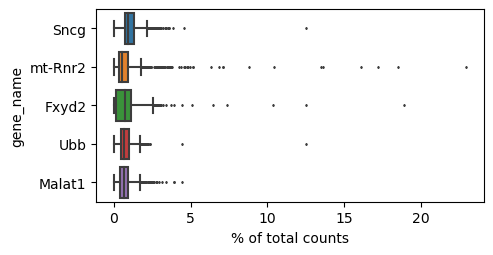

In [63]:
### Now we do QC in the downsample_version
### we need to read the t2g to be able to know which genes are mitochondrial!!!

t2g = pd.read_csv("t2g.txt", header=None, names=["tid", "gene_id", "gene_name"], sep="\t")
t2g.index = t2g.gene_id### FOR THAT WE USE T2G VARIABLE THAT OPENS T2G FILE (FILE WITH LINK BETWEEN GENE CODE AND GENE NAME)

t2g = t2g.loc[~t2g.index.duplicated(keep='first')]

adata.var["gene_id"] = adata.var.index.values
adata.var["gene_name"] = adata.var.gene_id.map(t2g["gene_name"])
adata.var.index = adata.var["gene_name"]

mt_gene_mask = np.flatnonzero([gene.startswith('mt-') for gene in adata.var_names])
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
y = np.sum(adata[:, mt_gene_mask].X, axis=1).A1.reshape(-1,)
z = np.array(adata.obs['n_counts']).reshape(-1,)

adata.obs['mt_frac'] = y/z

adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
sc.pl.highest_expr_genes(adata, n_top=5)

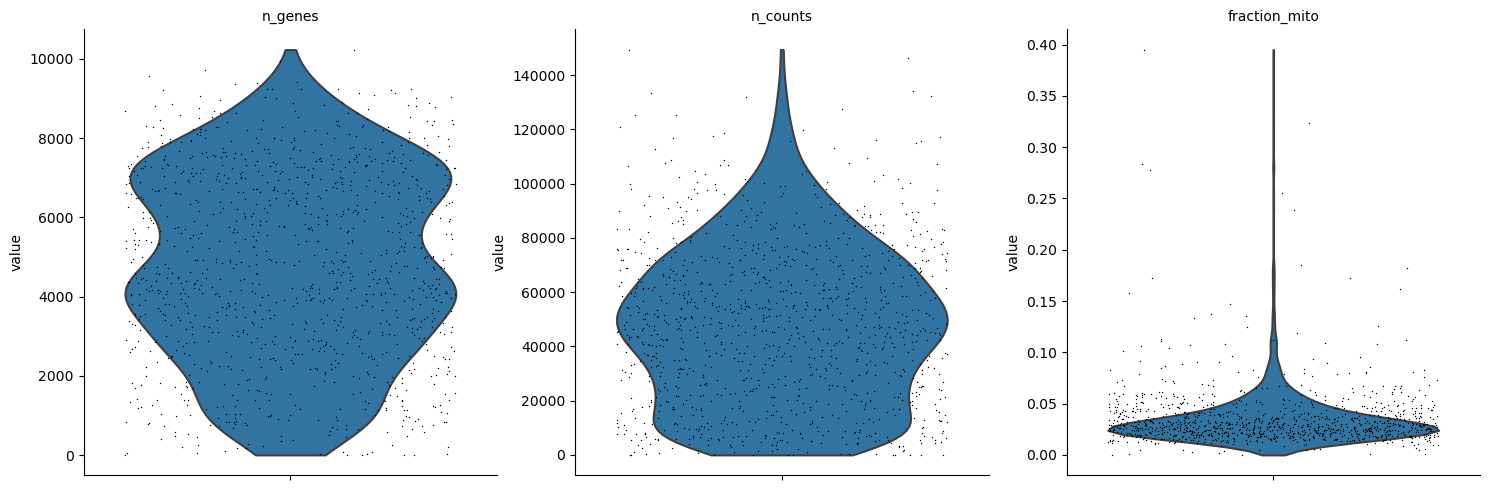

In [64]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
### check for mitochandrial mRNA
mito_genes = adata.var_names.str.startswith('mt-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)

#### change percent to fraction!!!!!

adata.obs['fraction_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1
sc.pl.violin(adata, ['n_genes', 'n_counts', 'fraction_mito'],
             jitter=0.4, multi_panel=True)


Total number of cells: 1152
Number of cells after min count filter: 1019
Total number of genes: 55421
(769, 17747)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


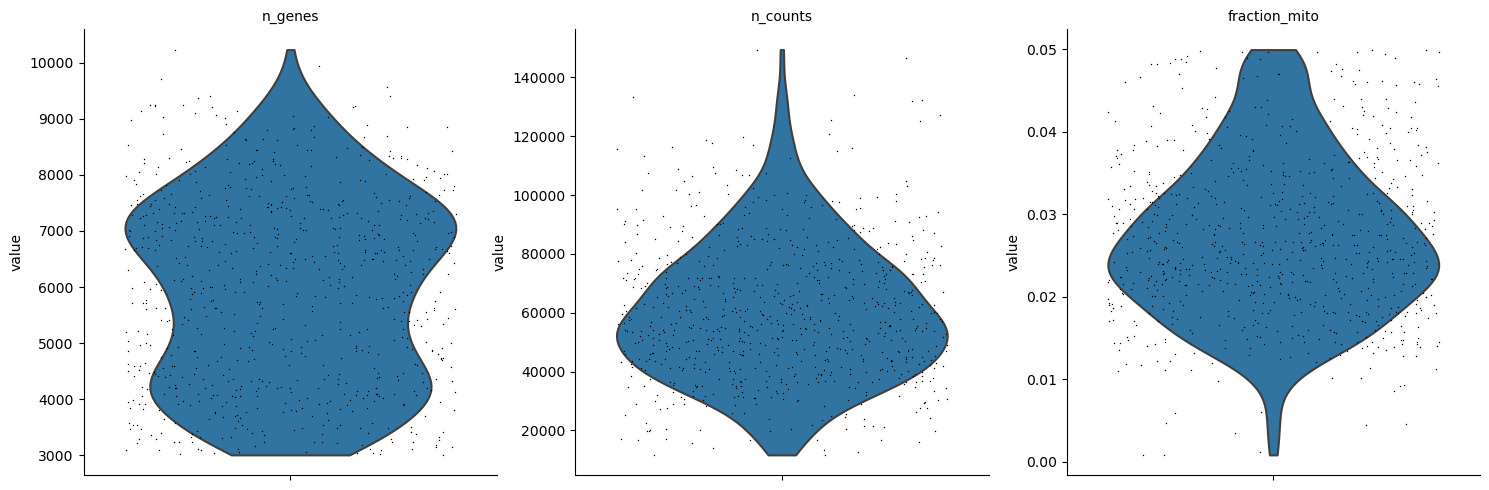

In [65]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))
sc.pp.filter_cells(adata, min_counts = 10000)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))
sc.pp.filter_cells(adata, min_genes = 3000)
print('Total number of genes: {:d}'.format(adata.n_vars))
sc.pp.filter_genes(adata, min_cells=5)
#mito_threshold = 0.05
#mito_list = []
#for i in range(len(adata.obs['fraction_mito'])):
#    mito_list.append(adata.obs['fraction_mito'][i])
#mito_list_thres = np.where(np.array(mito_list)<mito_threshold)[0]
#adata = adata[mito_list_thres,:]
adata = adata[adata.obs.pct_counts_mt < 5, :]
print(adata.shape)
sc.pl.violin(adata, ['n_genes', 'n_counts', 'fraction_mito'],
             jitter=0.4, multi_panel=True)


In [66]:
adata = adata[adata.obs.n_genes_by_counts < 12500, :]
print(adata.shape)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes= 15000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

(769, 17747)

 Number of highly variable genes: 15000


/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


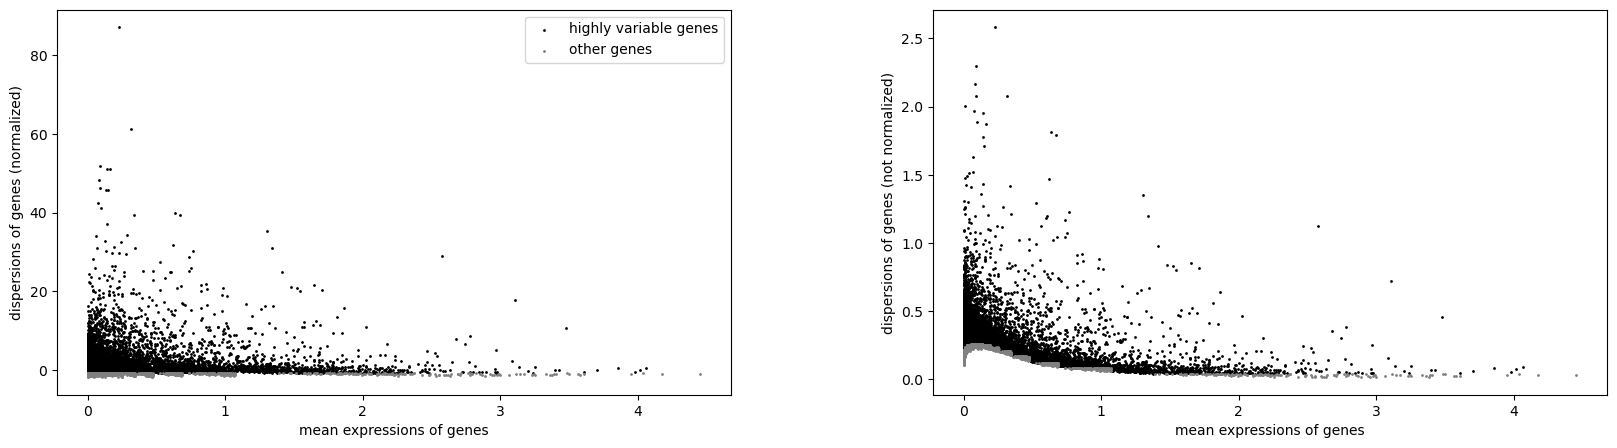

(769, 17747)


In [67]:
from matplotlib import rcParams

rcParams['figure.figsize']=(10,5)
sc.pl.highly_variable_genes(adata)

print(adata.shape)

In [68]:
!pip install hdf5plugin
import hdf5plugin

adata.var_names_make_unique() 

adata.write_h5ad(
    os.path.join(output_path , 'campari_scs_all_genes_'+str(fraction_downsample)+'.h5ad'),
#    compression=hdf5plugin.FILTERS["zstd"],
#    compression_opts=hdf5plugin.Zstd(clevel=5).filter_options
)

(769, 15000)


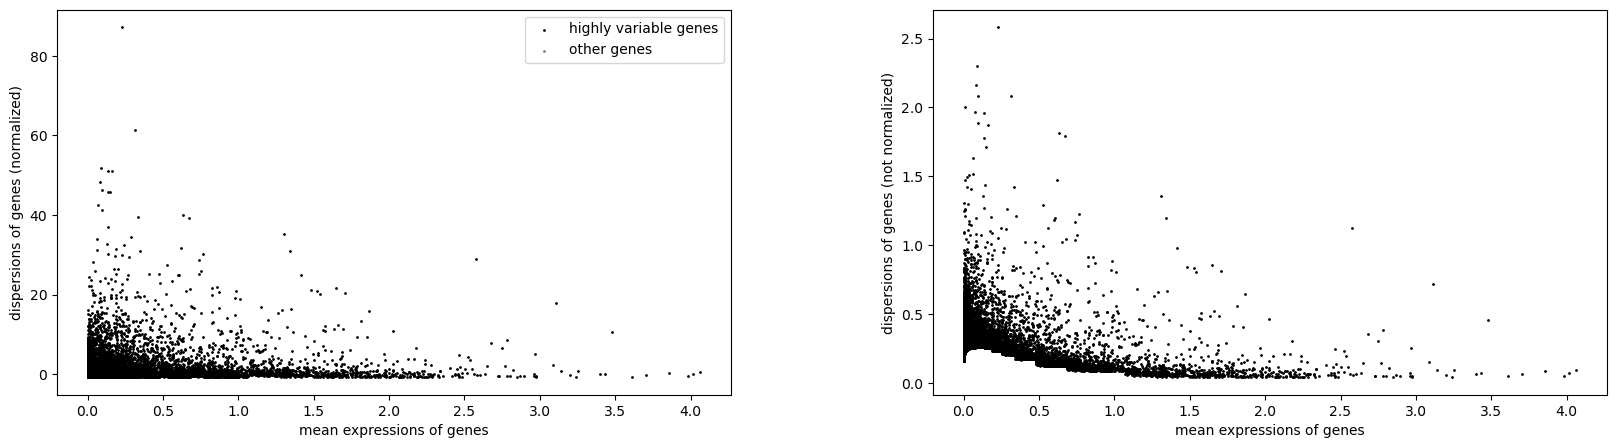

In [69]:
adata = adata[:, adata.var.highly_variable]
print(adata.shape)
sc.pl.highly_variable_genes(adata)

In [70]:

### check again regress_out!!!!!

sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [71]:
adata.write_h5ad(
    os.path.join(output_path , 'campari_scs_'+str(fraction_downsample)+'.h5ad'))

### SECTION II: Data analysis in the counts downsampled matrix

In [72]:
adata = ad.read_h5ad(os.path.join(input_path , 'campari_scs_'+str(fraction_downsample)+'.h5ad'))
adata_all = ad.read_h5ad(os.path.join(input_path ,'campari_scs_all_genes_'+str(fraction_downsample)+'.h5ad'))

print(adata.shape)

(769, 15000)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


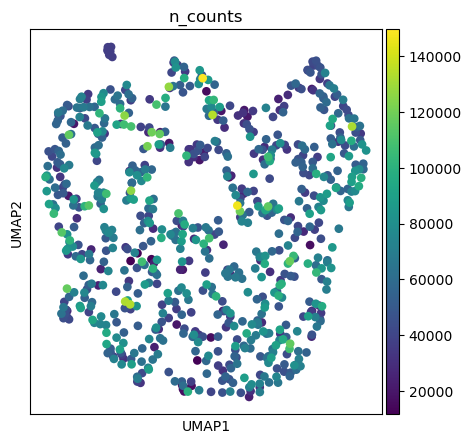

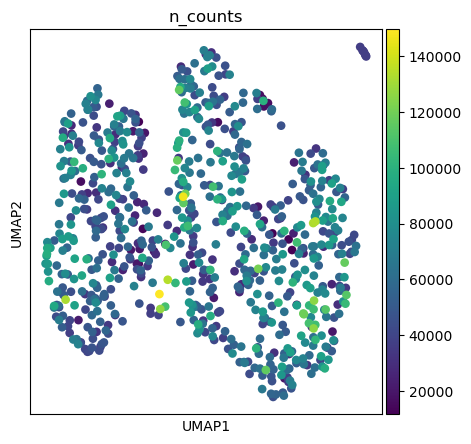

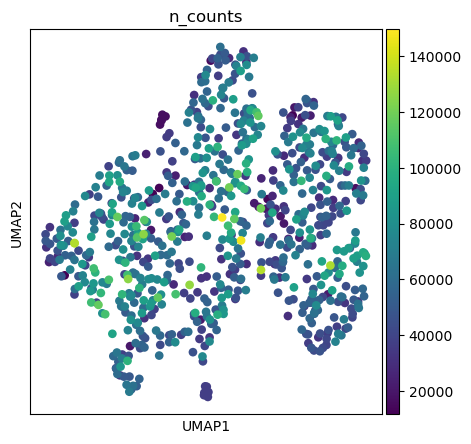

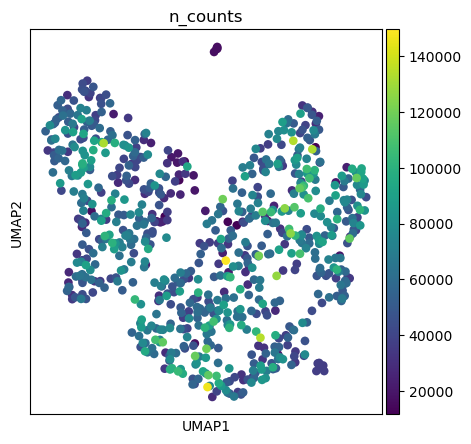

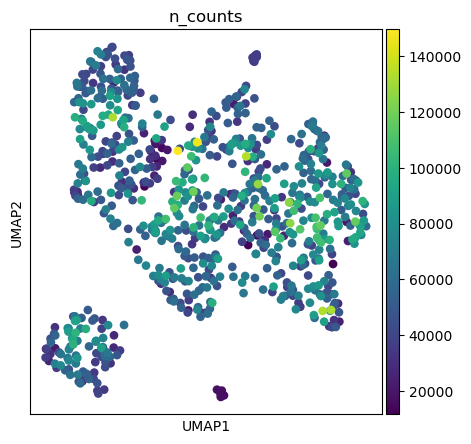

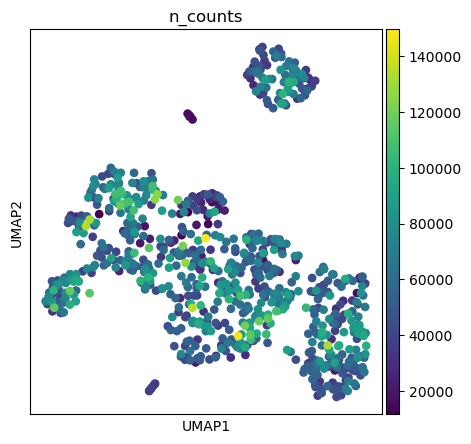

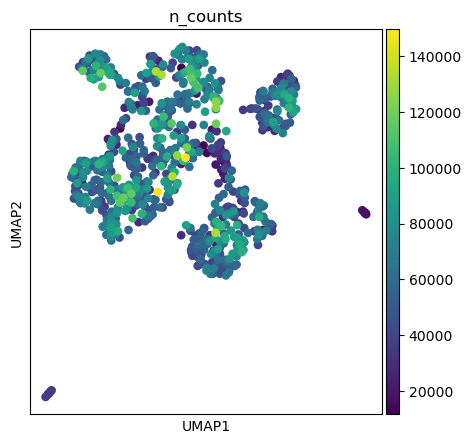

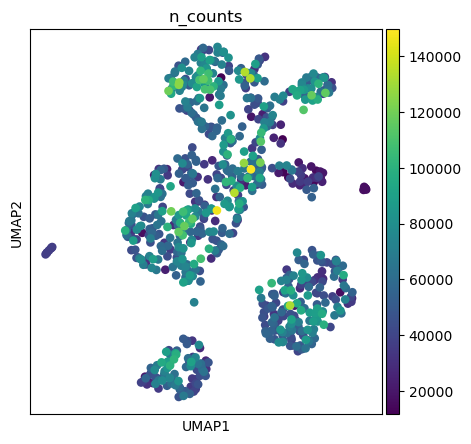

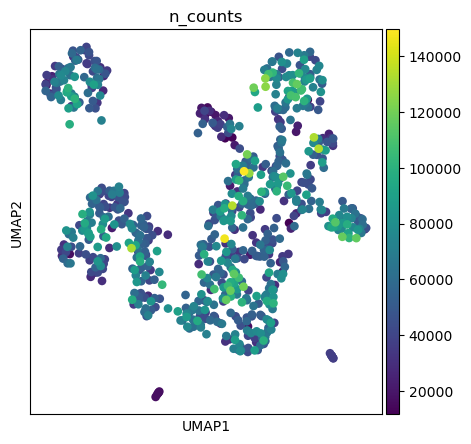

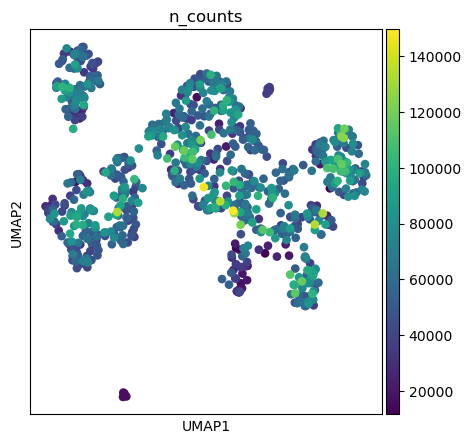

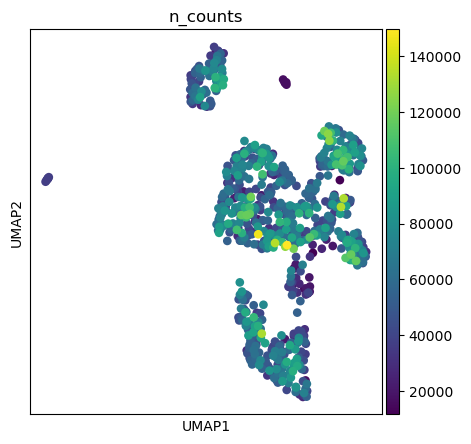

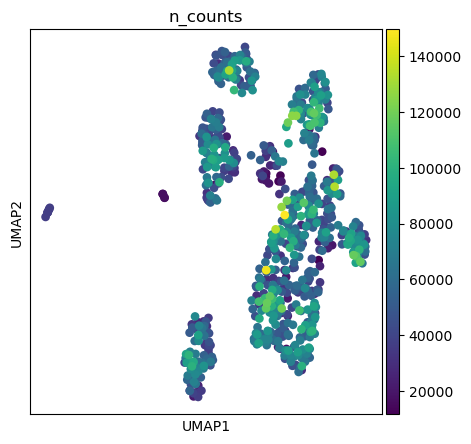

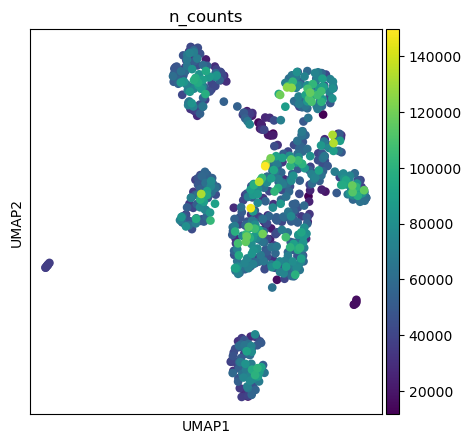

In [73]:
N_components = 15
rcParams['figure.figsize']=(5,5)

for n in range(2,N_components):
    sc.pp.pca(adata, n_comps=n, use_highly_variable=True, svd_solver='arpack')
#    sc.pp.pca(adata, n_comps=n, svd_solver='arpack')
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color='n_counts', save = 'UMIs/counts_downsample/pc_componets/pc_fraction_'+str(fraction_downsample)+'_'+ str(n) + '.png')

In [74]:
### Dimentionality reduction examples using multiple techniques
### Select one number of componets, for example n = 15 and do louvain in the umap transformation 
# with that number of componets
N_selected = 15
sc.pp.pca(adata, n_comps=N_selected, use_highly_variable=True, svd_solver='arpack')

#sc.pl.pca_variance_ratio(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)


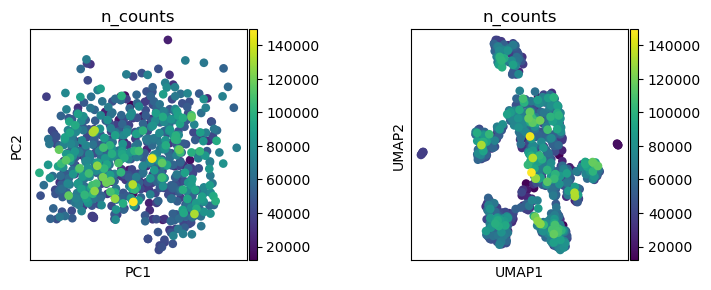

In [75]:
from matplotlib import rcParams

rcParams['figure.figsize']=(8,3)
fig_ind=np.arange(121, 123)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p10 = sc.pl.pca_scatter(adata, color='n_counts', ax=fig.add_subplot(fig_ind[0]), show=False)
p12 = sc.pl.umap(adata, color='n_counts', ax=fig.add_subplot(fig_ind[1]), show=False)

plt.show()

In [76]:
# Perform clustering - using highly variable genes ### maybe change to Leiden
louvain_paramenters = [0.3,0.5,1,1.5,2,2.5,3,3.5,4,4.5,6]
louvain_names = []
for value in louvain_paramenters:
    louvain_names.append('louvain_r' + str(value))

for value,name in zip(louvain_paramenters,louvain_names):
    sc.tl.louvain(adata, resolution=value, key_added=name)
    

/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


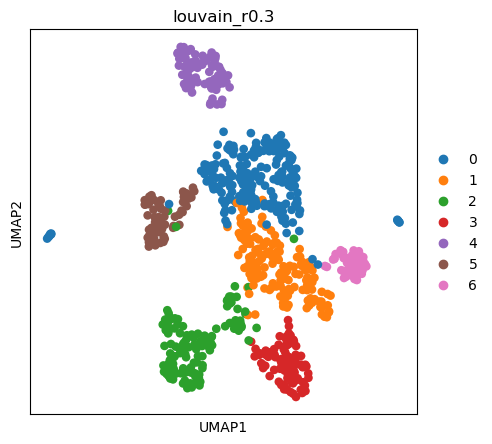

/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


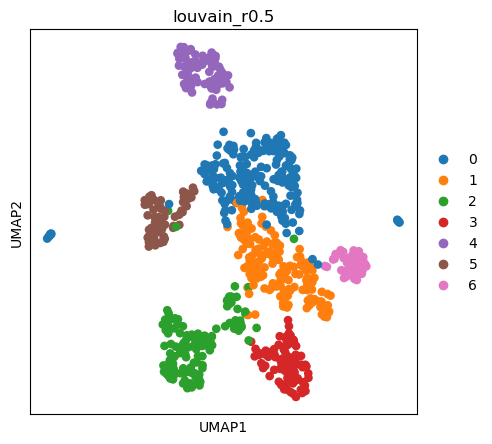

/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


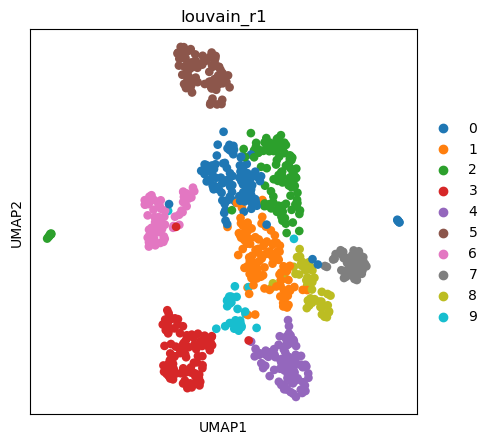

/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


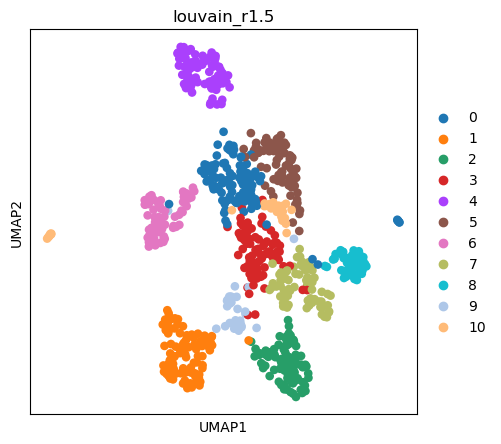

/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


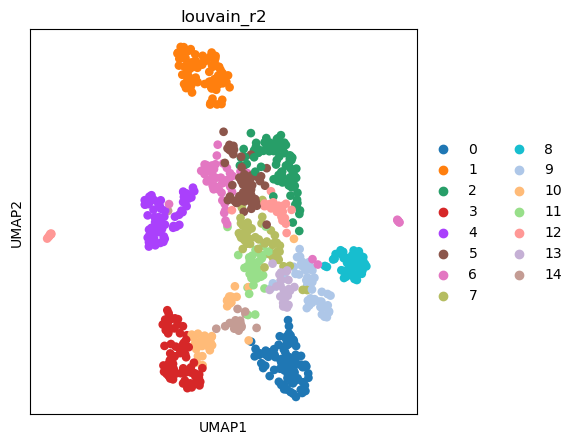

/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


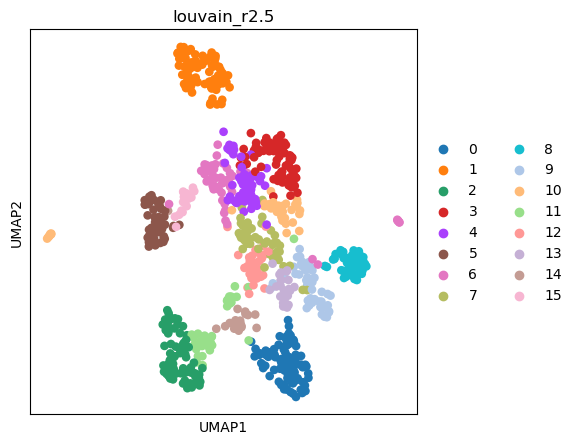

/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


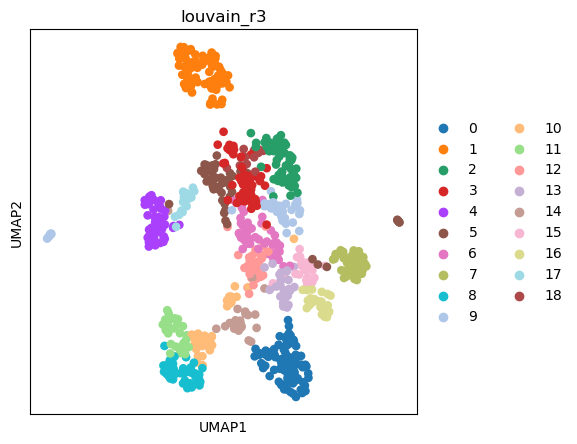

/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


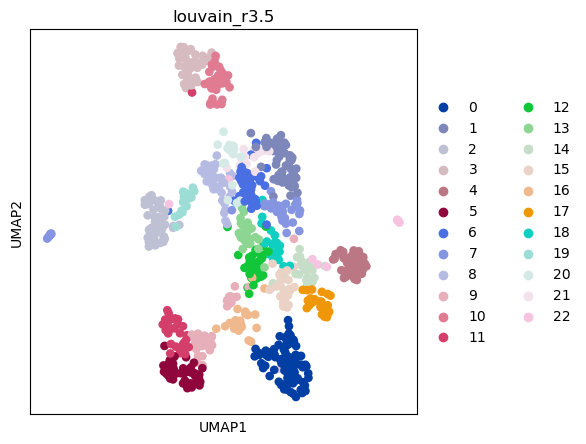

/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


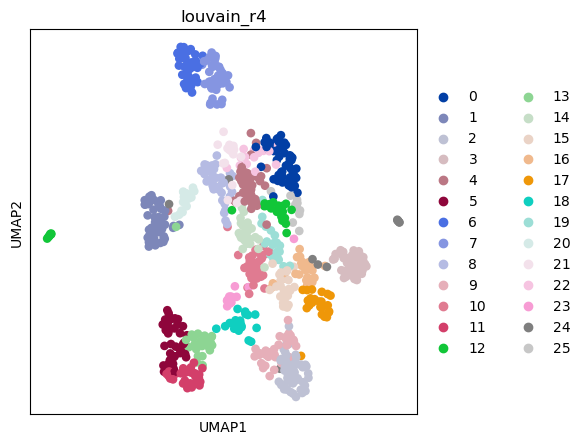

/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


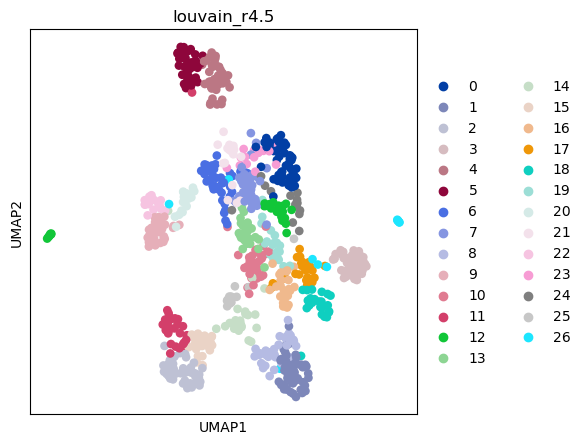

/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


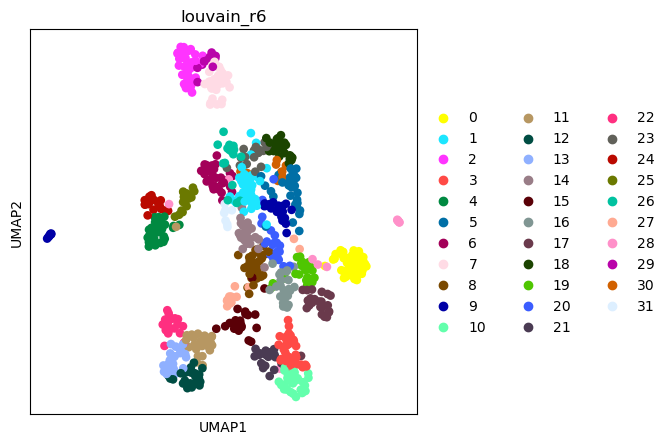

In [77]:
rcParams['figure.figsize']=(5,5)

#Visualize the clustering and how this is reflected by different technical covariates
for name in louvain_names:
    sc.pl.umap(adata, color=name, save = 'UMIs/counts_downsample/louvain/'+name +'_fraction_'+str(fraction_downsample) +'.png')
#sc.pl.umap(adata, color=['log_counts','stimuli'])

In [78]:
sc.tl.rank_genes_groups(adata, 'louvain_r2.5', method='wilcoxon')
rank_genes_df = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)

/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/melm

In [79]:
def unique(list1):
 
    # initialize a null list
    unique_list = []
    unique_index = []
 
    # traverse for all elements
    count = 0
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
            unique_index.append(count)
        count+=1
    return unique_list,unique_index
        
print(adata.shape)
gene_name = []
for i in range(len(adata.var['gene_name'])):
    gene_name.append(adata.var['gene_name'].iloc[i])

unique_genes , unique_genes_index = unique(gene_name)

adata = adata[:,np.array(unique_genes_index)]

(769, 15000)


/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/tools/_dendrogram.py:161: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = dat
/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


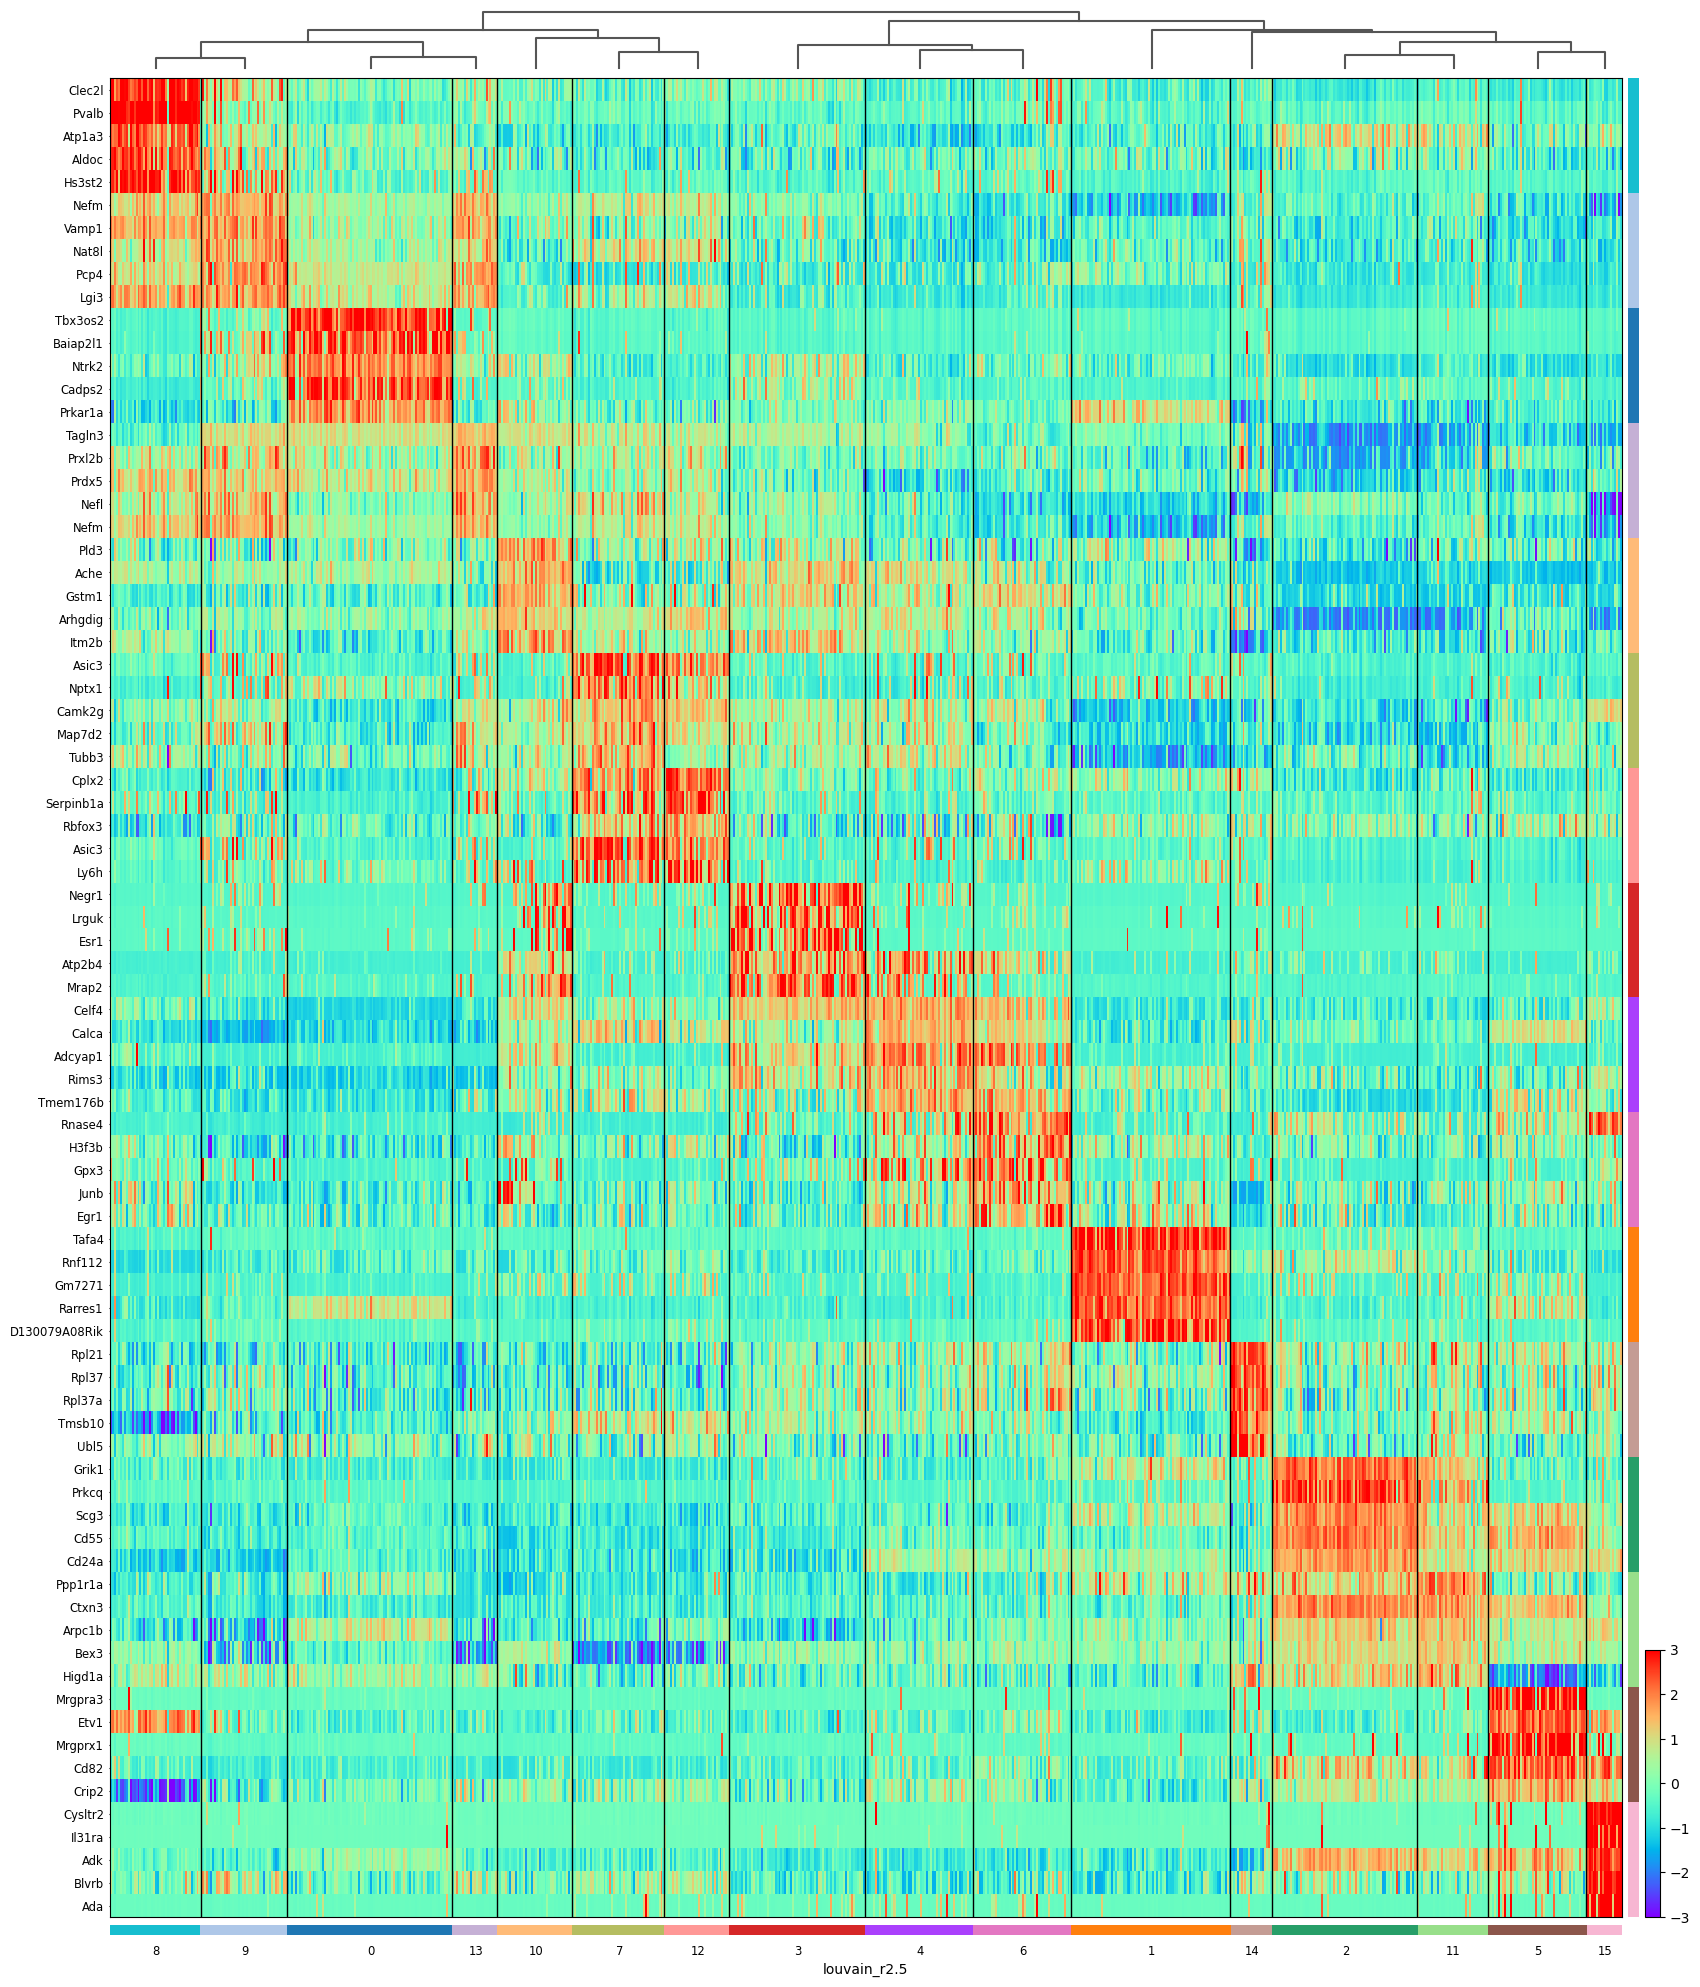

In [80]:
sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, use_raw=False, show_gene_labels=True,swap_axes=True, vmin=-3, vmax=3, cmap='rainbow', figsize=(20,25), show=True, 
                               save = 'UMIs/counts_downsample/characteristic_genes/'+'characteristic_genes_5_louvain_r2.5_fraction'+str(fraction_downsample) + '.png', dendrogram = True)

#sc.pl.rank_genes_groups_heatmap(adata, n_genes=10, use_raw=False, swap_axes=True, show_gene_labels=False,
#                                vmin=-3, vmax=3, cmap='bwr')


categories: 0, 1, 2, etc.
var_group_labels: RA-LTMR, C-LTMR, Itch, etc.


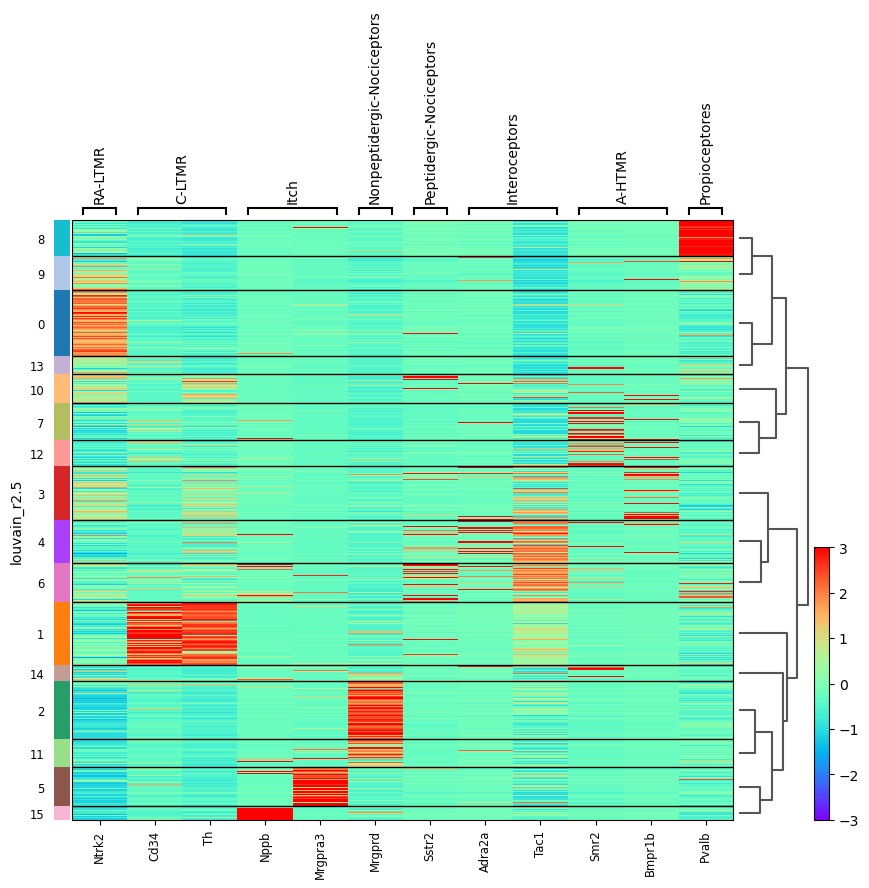

In [81]:
marker_genes_dict = {
    'RA-LTMR': ['Ntrk2'],
    'C-LTMR': ['Cd34', 'Th'],
    'Itch': ['Nppb','Mrgpra3'],
    'Nonpeptidergic-Nociceptors': ['Mrgprd'],
    'Peptidergic-Nociceptors': ['Sstr2'],
    'Interoceptors': ['Adra2a','Tac1'],
    'A-HTMR': ['Smr2','Bmpr1b'],
    'Propioceptores': ['Pvalb']
}

sc.pl.heatmap(adata, marker_genes_dict, groupby='louvain_r2.5', cmap='rainbow',figsize=(10,8), 
              show=True,show_gene_labels=True, dendrogram = True,vmin=-3,vmax=3,
                               save = 'UMIs/counts_downsample/characteristic_genes/'+'marker_genes_dict_louvain_r1_fraction'+str(fraction_downsample) + '.png')


In [88]:
### Define list of relevant genes 

marker_genes = ['Trpm3','Piezo2','Trpm2','Smr2','Sstr2','Bmpr1b','Trpv1','Piezo2','Piezo1','Nppb',
                'Sst','Pvalb','Prokr2','Mrgprd','Mrgpra3','Cd34',
                'Th','Trpa1','Ntrk3','Ntrk2','Ntrk1','Ret','Tac1','Calca','Calcb','Nefh',
                'S100b','Scn10a','Slc17a8','Atf3','Pou4f3','Calb1','Calb2','Avil','Asic3',
                'Asic2','Asic1','Pou6f2','Pou4f2','Sox10','Casq2','Trpm8']
marker_genes = ['Chrna7','Chrna3',
                'P2rx3','Ldhb','Necab2','Spp1','Adm','Hpse','Adra2a','Avpr1a']
marker_genes = ['Adra2a']


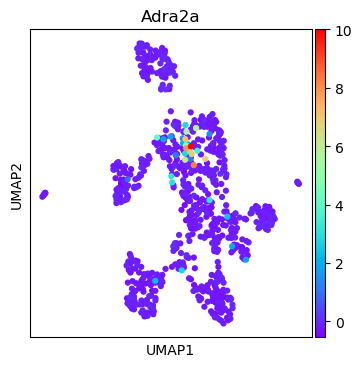

In [89]:
### Run plotting umap with color code according to gene expression
rcParams['figure.figsize']=(4,4)

np.in1d(marker_genes, adata.var_names)
for gene in marker_genes:
    sc.pl.umap(adata=adata, color=gene, use_raw=False, cmap = 'rainbow',save = 'UMIs/counts_downsample/expression/genes_'+ gene + 'fraction_'+str(fraction_downsample) + '.png', size = 80)

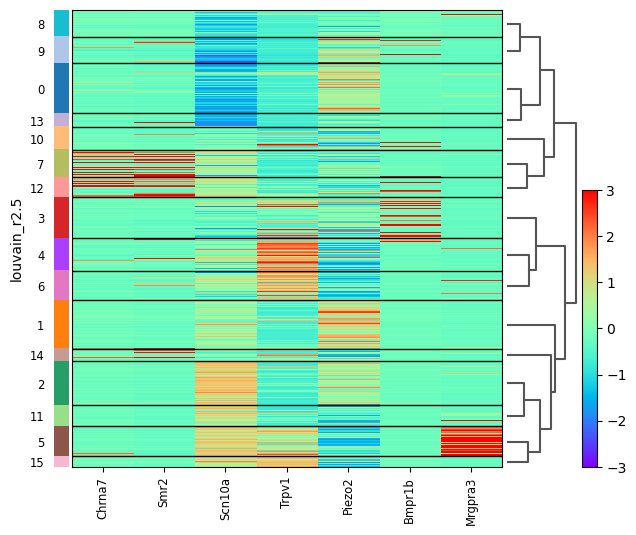

In [90]:
marker_genes = ['Chrna7','Smr2','Scn10a','Trpv1','Piezo2','Bmpr1b','Mrgpra3']
sc.pl.heatmap(adata, marker_genes, groupby='louvain_r2.5', cmap='rainbow',figsize=(7,6),vmin=-3,vmax=3, show=True,show_gene_labels=True, 
                               save = 'UMIs/counts_downsample/characteristic_genes/'+'marker_genes_3_louvain_r2.5_fraction'+str(fraction_downsample) + '.png', dendrogram = True)

#sc.pl.rank_genes_groups_heatmap(adata, n_genes=10, use_raw=False, swap_axes=True, show_gene_labels=False,
#                                vmin=-3, vmax=3, cmap='bwr')


In [91]:
#################################################################################
#################################################################################
#################################################################################
#################### HERE WE EXPORT ALL THE INFORMATION AS .MAT ################

### we export sparse data matrix, stimuli and flourecence information, umap transformation information and
### louvain transformation

### create and exportable varable list of genes names
gene_name = []
for i in range(len(adata.var['gene_name'])):
    gene_name.append(adata.var['gene_name'].iloc[i])
    
gene_name_all = []
for i in range(len(adata_all.var['gene_name'])):
    gene_name_all.append(adata_all.var['gene_name'].iloc[i])
### transform adata sparse matrix to scipy
x_all = scipy.sparse.csr_matrix.toarray(adata_all.X)
x = adata.X
### create exportable arrays with information about stimuli, fluorecence, and louvain transformations
stim = np.zeros((x.shape[0],))
red = np.zeros((x.shape[0],))
green = np.zeros((x.shape[0],))
louvain = np.zeros((x.shape[0],len(louvain_names)))
for i in range(x.shape[0]):
    stim[i] = adata.obs['stimulus'][i]
    red[i] = adata.obs['red'][i]
    green[i] = adata.obs['green'][i]
    count = 0
    for name in louvain_names:
        louvain[i,count] = adata.obs[name][i]
        count = count + 1
data = {'umap': adata.obsm['X_umap'],'gene_name' : np.array(gene_name_all),'gene_name_matrix' : np.array(gene_name),
        'sparse_matrix': x_all,'matrix': x,'stimuli':stim,
        'red_intesity': red, 'green_intensity': green, 'louvain' : louvain, 'louvain_name': louvain_names}

scipy.io.savemat(os.path.join(input_path , 'umap_fraction_'+str(fraction_downsample)+'_date_'+str(today)+'.mat'), data) ### os.join path  + time so no manual!
